In [192]:
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot
plt.rc("font", size=10)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn import metrics
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler


# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
# sns.set(style="white")
# sns.set(style="whitegrid", color_codes=True)

In [193]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
         
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0])
                                  , range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    



In [194]:
def show_most_informative_features(vectorizer, clf, n=20):
    print("most informative words:")
    feature_names = vectorizer.get_feature_names()
    coef=clf.coef_[0]
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    

In [195]:
path = "../../data/processed/stylo_cupid2_liwc.csv"
filepath = os.path.join(os.path.dirname(os.path.abspath("__file__")), path)
df = pd.read_csv(filepath)


df.rename(columns={'A':'age', 'B':'sex', 'C':'text', 'D':'isced', 'E': 'isced2', 'F': '#anwps', 'G':'clean_text', 'H': 'count_char', 'I':'count_punct', 'J':'count_word', 'K':'avg_wordlength', 'L':'count_misspelled', 'M':'word_uniqueness'}, inplace=True)
df.dropna(subset=['isced', 'clean_text'], inplace=True)
df['isced'].mask(df['isced'].isin([3.0, 5.0, 1.0]) , 0, inplace=True)
df['isced'].mask(df['isced'].isin([6.0, 7.0, 8.0]) , 1, inplace=True)
df['clean_text'] = df['clean_text'].str.replace('\d+', ' ')


clean_text = df['clean_text']
target = df.isced
meta = df.iloc[:, 5:13]
liwc = df.iloc[:, 13:]
liwc.replace(',','.',inplace=True,  regex=True)
liwc= liwc.astype(float)
liwc_text = pd.concat([liwc, clean_text], axis=1)

# LIWC Output

In [196]:
liwc.head()

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,359.0,83.13,55.53,40.11,94.26,12.82,17.55,83.29,48.47,12.81,...,3.34,0.84,0.00,0.00,0.28,0.00,0.00,0.84,1.11,0.00
1,462.0,63.78,42.28,77.54,70.57,14.90,30.52,82.03,46.10,13.64,...,8.87,0.00,0.00,0.00,0.00,0.43,0.87,3.03,1.73,0.00
2,39.0,71.92,60.13,46.75,73.64,19.50,33.33,87.18,41.03,12.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,65.0,93.26,43.89,63.54,99.00,10.83,20.00,76.92,30.77,9.23,...,3.08,1.54,0.00,1.54,0.00,0.00,0.00,3.08,0.00,7.69
4,252.0,28.34,22.55,96.82,99.00,10.08,20.24,86.90,48.81,19.84,...,1.98,0.40,0.79,0.00,0.40,0.40,0.00,5.56,1.59,0.00


# Summary statistics

In [197]:
liwc.describe()

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
count,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,...,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000,49924.000000
mean,242.538999,60.977513,39.092714,74.946700,86.834321,17.425879,20.868292,85.137344,48.125206,14.368579,...,6.500606,0.227498,0.243650,0.270982,0.706477,1.051619,0.360719,2.959958,1.054669,0.857163
std,194.471005,20.663227,19.133353,21.355359,21.179731,11.494488,5.741940,5.441619,6.260266,4.088986,...,5.424975,1.885077,1.569959,1.925676,2.455205,2.472011,0.859147,2.242098,4.606400,28.922824
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,116.000000,46.830000,24.970000,64.410000,84.640000,11.910000,17.650000,82.580000,45.210000,12.070000,...,3.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.350000,0.000000,0.000000
50%,201.000000,62.345000,36.660000,80.780000,97.780000,15.430000,20.510000,85.490000,48.790000,14.380000,...,5.930000,0.000000,0.000000,0.000000,0.000000,0.490000,0.000000,2.810000,0.510000,0.000000
75%,318.000000,76.765000,50.000000,91.310000,99.000000,20.000000,23.700000,88.150000,51.900000,16.670000,...,8.390000,0.280000,0.000000,0.330000,0.810000,1.410000,0.420000,4.260000,1.620000,0.780000
max,8769.000000,99.000000,99.000000,99.000000,99.000000,392.000000,100.000000,100.000000,100.000000,100.000000,...,700.000000,392.680000,270.730000,400.000000,300.000000,338.380000,33.330000,100.000000,971.430000,6282.140000


# Text classification by Logistic regression(Bag of words)

Final Accuracy for Logistic: 0.8147633799807713
              precision    recall  f1-score   support

         0.0       0.58      0.59      0.58      2059
         1.0       0.88      0.88      0.88      7302

    accuracy                           0.81      9361
   macro avg       0.73      0.73      0.73      9361
weighted avg       0.82      0.81      0.82      9361

Confusion matrix, without normalization
[[1215  844]
 [ 890 6412]]


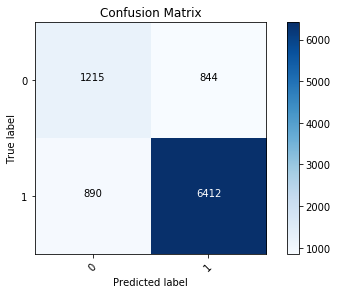

In [7]:
Xt_rest,Xt_test, yt_rest, yt_test = train_test_split(clean_text, target, stratify=target, test_size = 0.25, random_state=0)
Xt_train, Xt_val, yt_train, yt_val = train_test_split(Xt_rest, yt_rest, stratify=yt_rest, test_size = 0.25, random_state=0)
clf_text = Pipeline([('vec', CountVectorizer(max_df=0.60, max_features=200000, stop_words='english', binary=True, lowercase=True, ngram_range=(1, 2))),
                    ('clf', LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))])
clf_text.fit(Xt_train, yt_train)

# clf_text = make_pipeline(CountVectorizer(ngram_range=(1, 2)), LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced')).fit(Xt_train, yt_train)
predictions_t = clf_text.predict(Xt_val)

# RandomOverSampler(),


print("Final Accuracy for Logistic: %s"% accuracy_score(yt_val, predictions_t))
cm = confusion_matrix(yt_val,predictions_t)
print(classification_report(yt_val, predictions_t))
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')


In [9]:
show_most_informative_features(clf_text.get_params()['vec'], clf_text.get_params()['clf'], n=15)

most informative words:
	-1.9546	majoring       		2.5959	grad           
	-1.4109	semester       		2.3593	graduated      
	-1.4023	going college  		2.2671	masters        
	-1.3921	studying       		1.9423	phd            
	-1.3905	going school   		1.7876	mba            
	-1.3904	major          		1.4892	skiing         
	-1.3061	time student   		1.4587	law school     
	-1.2843	school work    		1.3583	graduate       
	-1.2479	ask ask        		1.3347	graduate student
	-1.2355	finishing degree		1.1629	graduate school
	-1.2113	finishing      		1.1460	engineer       
	-1.2011	transfer       		1.1249	mfa            
	-1.1444	school         		1.1124	teacher        
	-1.1231	skateboarding  		1.0918	teaching       
	-1.1122	student        		1.0743	law            


### Lasso for bag of words

In [132]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem.snowball import FrenchStemmer

# stemmer = FrenchStemmer()
# analyzer = CountVectorizer().build_analyzer()

# def stemmed_words(doc):
#     return (stemmer.stem(w) for w in analyzer(doc))
# analyzer=stemmed_words,


Xt_rest,Xt_test, yt_rest, yt_test = train_test_split(clean_text, target, stratify=target, test_size = 0.25, random_state=0)
Xt_train, Xt_val, yt_train, yt_val = train_test_split(Xt_rest, yt_rest, stratify=yt_rest, test_size = 0.25, random_state=0)

vectorizer = CountVectorizer(min_df=0.00, max_df=0.60, max_features=1000, stop_words='english', binary=True, lowercase=True,  ngram_range=(1, 2))
grams = vectorizer.fit_transform(Xt_train)
words = vectorizer.get_feature_names()




In [133]:
reg = LassoCV(max_iter=1000)
model_lasso = reg.fit(grams, yt_train)

In [134]:

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(grams,yt_train))
coef = pd.Series(reg.coef_, index = words)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.000357
Best score using built-in LassoCV: 0.258824
Lasso picked 561 variables and eliminated the other 439 variables


In [135]:
imp_coef = coef.sort_values()
new_col = imp_coef.nlargest(565)
cols = new_col.index.tolist()
cols

['grad',
 'masters',
 'graduated',
 'graduate',
 'law',
 'teacher',
 'teaching',
 'went',
 'engineer',
 'research',
 'startup',
 'nonprofit',
 'traveled',
 'skiing',
 'easygoing',
 'accent',
 'dinner',
 'travel',
 'tennis',
 'curious',
 'museums',
 'software',
 'catching',
 'wine',
 'chemistry',
 'question',
 'sf',
 'balance',
 'week',
 'career',
 'professional',
 'smart',
 'genuine',
 'connection',
 'asian',
 'finished',
 'nyc',
 'teach',
 'figuring',
 'low',
 'traveling',
 'spent',
 'coast',
 'project',
 'thoughtful',
 'french',
 'job',
 'currently working',
 'worked',
 'company',
 'countries',
 'excited',
 'friends',
 'high school',
 'public',
 'moved',
 'yes',
 'order',
 'exploring',
 'dating',
 'la',
 'concert',
 'large',
 'hour',
 'yoga',
 'driven',
 'books',
 'passionate',
 'gym',
 'snowboarding',
 'value',
 'basketball',
 'stories',
 'running',
 'karaoke',
 'bay',
 'dancing',
 'bike',
 'meal',
 'points',
 'save',
 'firm',
 'restaurants',
 'offer',
 'think',
 'bar',
 'hiking',
 

### Logistic Regression for bag of words with selected features

Final Accuracy for Logistic: 0.6514261296869992
              precision    recall  f1-score   support

         0.0       0.36      0.75      0.48      2059
         1.0       0.90      0.63      0.74      7302

    accuracy                           0.65      9361
   macro avg       0.63      0.69      0.61      9361
weighted avg       0.78      0.65      0.68      9361

Confusion matrix, without normalization
[[1534  525]
 [2738 4564]]


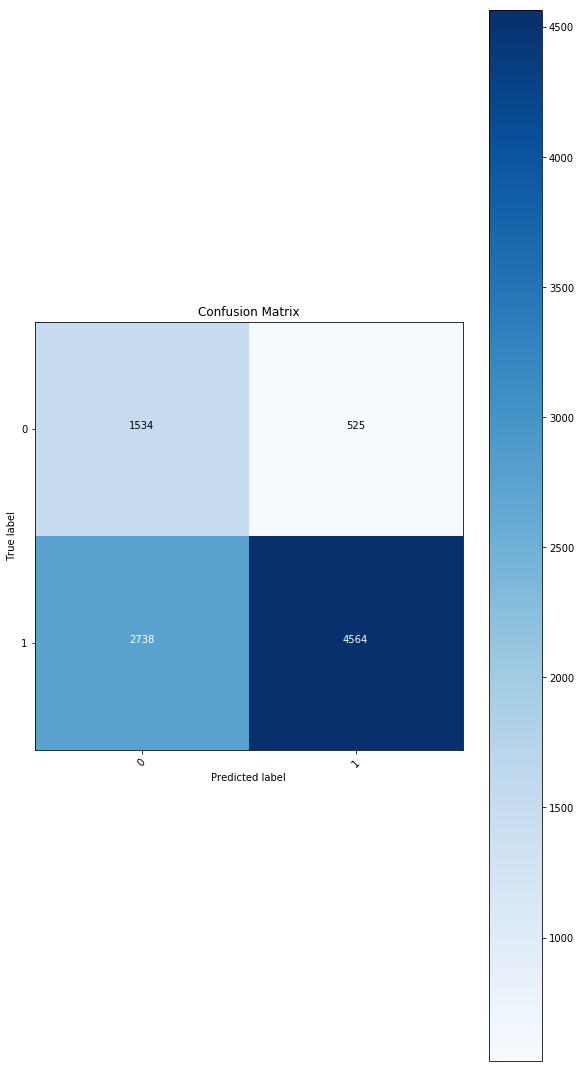

In [136]:
countvec_subset = CountVectorizer(vocabulary= cols)
Xt_train_subset = countvec_subset.fit_transform(Xt_train)
Xt_val_subset = countvec_subset.transform(Xt_val)
c = LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced')
c.fit(Xt_train_subset, yt_train)
p = c.predict(Xt_val_subset)
print("Final Accuracy for Logistic: %s"% accuracy_score(yt_val, p))
cm = confusion_matrix(yt_val,p)
print(classification_report(yt_val, p))
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')

In [137]:
show_most_informative_features(countvec_subset, c, n=20)

most informative words:
	-0.3452	science        		1.6521	grad           
	-0.3054	theater        		1.0882	masters        
	-0.3047	minded         		0.9421	graduated      
	-0.3037	painting       		0.8559	nyc            
	-0.2626	plans          		0.8249	skiing         
	-0.2564	wanted         		0.7382	traveled       
	-0.2519	riding         		0.7116	startup        
	-0.2454	yeah           		0.6985	museums        
	-0.2366	raised         		0.6832	nonprofit      
	-0.2313	using          		0.6565	countries      
	-0.2218	needs          		0.6447	balance        
	-0.2207	reason         		0.6415	thoughtful     
	-0.2169	language       		0.5896	engineer       
	-0.2154	quickly        		0.5508	software       
	-0.2064	nerd           		0.5186	research       
	-0.1928	natural        		0.5184	dinner         
	-0.1923	various        		0.5050	hour           
	-0.1879	types          		0.5040	accent         
	-0.1874	ofthe          		0.5019	catching       
	-0.1819	respect        		0.5015	law         

# The Logistic regression(Text+ Language features)


Final Accuracy for Logistic: 0.828757611366307
Confusion matrix, without normalization
[[1147  912]
 [ 691 6611]]
              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59      2059
         1.0       0.88      0.91      0.89      7302

    accuracy                           0.83      9361
   macro avg       0.75      0.73      0.74      9361
weighted avg       0.82      0.83      0.83      9361



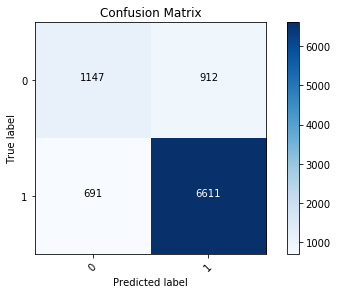

In [79]:
Xtm_rest,Xtm_test, ytm_rest, ytm_test = train_test_split(meta, target, stratify=target, test_size = 0.25, random_state=0)
Xtm_train, Xtm_val, ytm_train, ytm_val = train_test_split(Xtm_rest, ytm_rest, stratify=ytm_rest, test_size = 0.25, random_state=0)

cols = meta.loc[:, meta.columns != 'clean_text'].columns


get_text_data = FunctionTransformer(lambda x: x['clean_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[cols], validate=False)

process_and_join_features = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())
                
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True))
            ]))
         ])), 
    ('clf', LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
])



# merge vectorized text data and scaled numeric data
process_and_join_features.fit(Xtm_train, ytm_train)
predictions_tm = process_and_join_features.predict(Xtm_val)


print("Final Accuracy for Logistic: %s"% accuracy_score(ytm_val, predictions_tm))
cm = confusion_matrix(ytm_val,predictions_tm)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(ytm_val, predictions_tm))

In [145]:
show_most_informative_features(process_and_join_features.get_params()['features'].get_params()['text_features'].get_params()['vec'], process_and_join_features.get_params()['clf'], n=20)


most informative words:
	-1.5590	majoring performing		2.2883	grad schoolover
	-1.4212	going shortest 		2.0824	graduated ended
	-1.3463	studying cancer		2.0578	masters ecd    
	-1.3228	major changes  		1.4839	phd free       
	-1.2291	st josephs     		1.3371	graduate imhoping
	-1.2148	student butthat		1.3189	mba international
	-1.2094	finishing gradschool		1.2091	skiing couldspend
	-1.1698	going goofylove		1.0918	teacher city   
	-1.0847	semester spain 		1.0832	law imgood     
	-1.0660	going countrywithout		1.0390	teaching bringing
	-1.0482	schoola cashier		1.0156	lawenforcementi
	-1.0142	school ametalsmithartist		0.9822	engineer creative
	-0.9932	thats rollyou  		0.9581	grade andpossibly
	-0.9544	time tahoeinstead		0.8717	graduated boston
	-0.9364	tattoos ears   		0.8184	educated elegant
	-0.9117	bachelors wasting		0.8134	graduateconsidered
	-0.9074	skateboardyou  		0.7670	snowboarding doodling
	-0.8826	smoking making 		0.7397	nyc eventually 
	-0.8773	happy receivenot		0.7376	balance bo

### selected features from language features

In [86]:
meta = meta.loc[:, meta.columns != 'clean_text']
X_train_meta,X_test_meta, y_train_meta, y_test_meta = train_test_split(meta, target,stratify=target, test_size = 0.25, random_state=0)

scaler = StandardScaler()
meta_scaled = scaler.fit_transform(X_train_meta)
reg = LassoCV(max_iter=10000)
reg.fit(meta_scaled, y_train_meta)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(meta_scaled,y_train_meta))
coef = pd.Series(reg.coef_, index = meta.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.000061
Best score using built-in LassoCV: 0.031329
Lasso picked 7 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

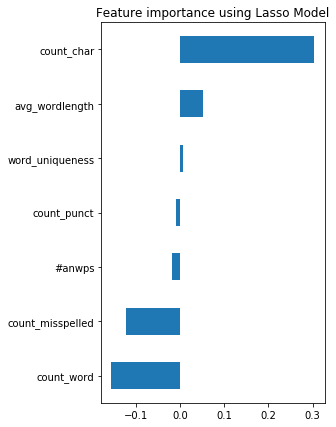

In [95]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (4.0, 7.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

# The Logistic regression (LIWC only)

Final Accuracy for Logistic: 0.6965067834633052
Confusion matrix, without normalization
[[1332  727]
 [2114 5188]]
              precision    recall  f1-score   support

         0.0       0.39      0.65      0.48      2059
         1.0       0.88      0.71      0.79      7302

    accuracy                           0.70      9361
   macro avg       0.63      0.68      0.63      9361
weighted avg       0.77      0.70      0.72      9361



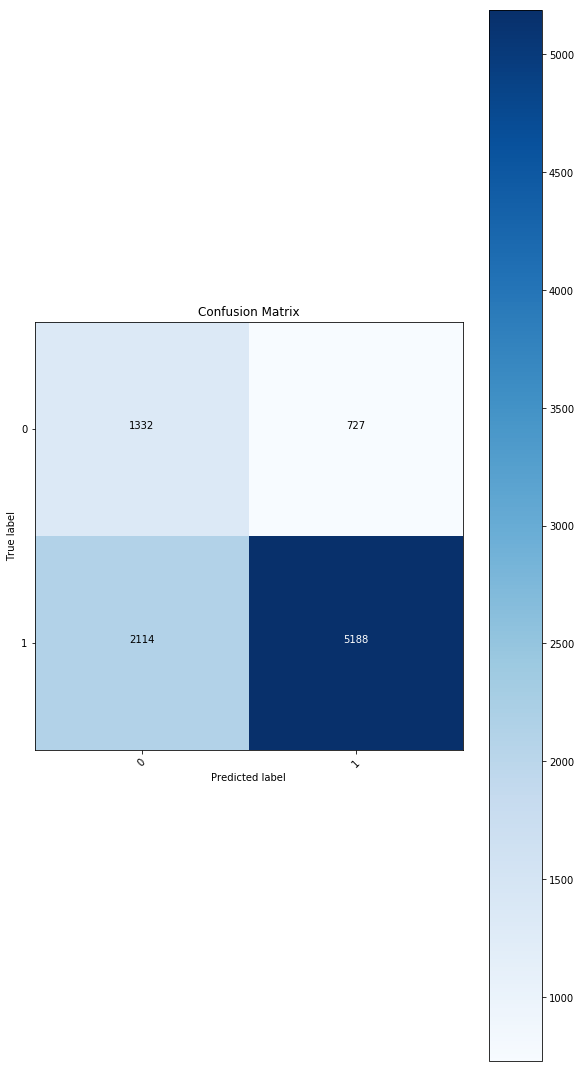

In [198]:
Xl_rest,Xl_test, yl_rest, yl_test = train_test_split(liwc, target, stratify=target, test_size = 0.25, random_state=0)
Xl_train, Xl_val, yl_train, yl_val = train_test_split(Xl_rest, yl_rest, stratify=yl_rest, test_size = 0.25, random_state=0)


scaler = preprocessing.StandardScaler()
Xl_train_scaled = scaler.fit_transform(Xl_train)
Xl_val_scaled = scaler.transform(Xl_val)


LogisticRegr = LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced')
LogisticRegr.fit(Xl_train_scaled, yl_train)
predictions = LogisticRegr.predict(Xl_val_scaled)



print("Final Accuracy for Logistic: %s"% accuracy_score(yl_val, predictions))
cm = confusion_matrix(yl_val,predictions)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(yl_val, predictions))


Text(0.5, 1.0, 'Feature importance ')

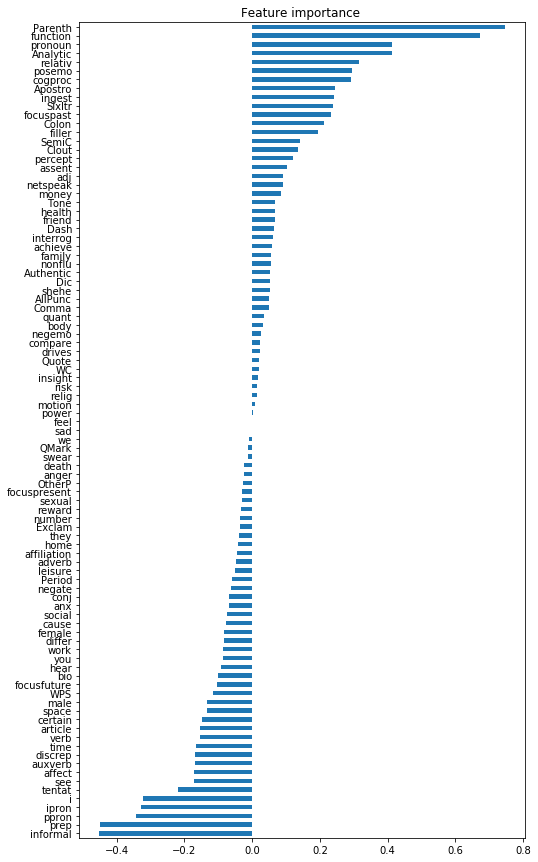

In [169]:
# importance = LogisticRegr.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

coef_liwc = pd.Series(LogisticRegr.coef_[0], index = liwc.columns)

imp_coef_liwc = coef_liwc.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 15.0)
imp_coef_liwc.plot(kind = "barh")
plt.title("Feature importance ")


## Lasso for Liwc

Best alpha using built-in LassoCV: 0.006008
Best score using built-in LassoCV: 0.096257
Lasso picked 41 variables and eliminated the other 52 variables
Final Accuracy for Logistic: 0.6914859523555176
Confusion matrix, without normalization
[[1349  710]
 [2178 5124]]
              precision    recall  f1-score   support

         0.0       0.38      0.66      0.48      2059
         1.0       0.88      0.70      0.78      7302

    accuracy                           0.69      9361
   macro avg       0.63      0.68      0.63      9361
weighted avg       0.77      0.69      0.71      9361



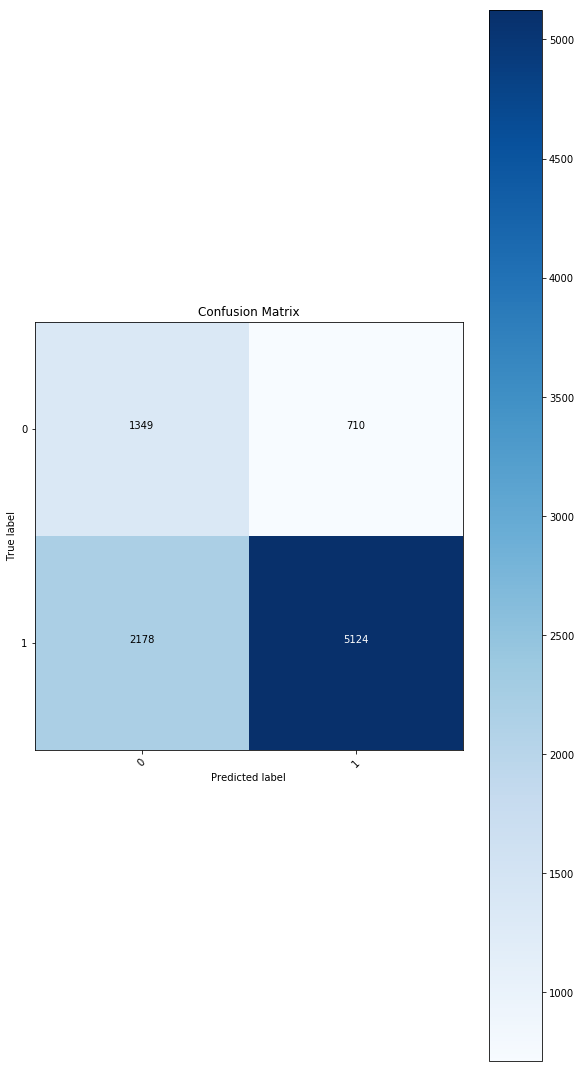

In [177]:
X_train,X_test, y_train, y_test = train_test_split(liwc, target,stratify=target, test_size = 0.25, random_state=0)

scaler = StandardScaler()
liwc_scaled = scaler.fit_transform(X_train)
reg = LassoCV(max_iter=10000)
reg.fit(liwc_scaled, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(liwc_scaled,y_train))
coef = pd.Series(reg.coef_, index = liwc.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
# import matplotlib
# matplotlib.rcParams['figure.figsize'] = (8.0, 15.0)
# imp_coef.plot(kind = "barh")
# plt.title("Feature importance using Lasso Model")

new_col = abs(imp_coef).nlargest(43)

new_liwc = liwc[new_col.index]
text = df['clean_text']
liwc_text_new = pd.concat([new_liwc, text], axis=1)

Xl_rest,Xl_test, yl_rest, yl_test = train_test_split(new_liwc, target, stratify=target, test_size = 0.25, random_state=0)
Xl_train, Xl_val, yl_train, yl_val = train_test_split(Xl_rest, yl_rest, stratify=yl_rest, test_size = 0.25, random_state=0)


scaler = preprocessing.StandardScaler()
Xl_train_scaled = scaler.fit_transform(Xl_train)
Xl_val_scaled = scaler.transform(Xl_val)


LogisticRegr = LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced')
LogisticRegr.fit(Xl_train_scaled, yl_train)
predictions = LogisticRegr.predict(Xl_val_scaled)



print("Final Accuracy for Logistic: %s"% accuracy_score(yl_val, predictions))
cm = confusion_matrix(yl_val,predictions)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(yl_val, predictions))

In [188]:
n = 10
print("most informative words:")
feature_names = Xl_train.columns
coef=LogisticRegr.coef_[0]
coefs_with_fns = sorted(zip(LogisticRegr.coef_[0], feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

most informative words:
	-0.1797	i              		0.7772	Parenth        
	-0.1541	informal       		0.2374	focuspast      
	-0.1416	verb           		0.2146	Sixltr         
	-0.1306	netspeak       		0.1941	Colon          
	-0.1236	swear          		0.1889	ingest         
	-0.1214	discrep        		0.1578	insight        
	-0.1085	focusfuture    		0.1115	article        
	-0.1081	WPS            		0.1105	posemo         
	-0.1037	see            		0.1086	motion         
	-0.0833	male           		0.1043	adj            


# The Logistic regression (Bag of words + LIWC)

Final Accuracy for Logistic: 0.8303600042730478
Confusion matrix, without normalization
[[1158  901]
 [ 687 6615]]
              precision    recall  f1-score   support

         0.0       0.63      0.56      0.59      2059
         1.0       0.88      0.91      0.89      7302

    accuracy                           0.83      9361
   macro avg       0.75      0.73      0.74      9361
weighted avg       0.82      0.83      0.83      9361



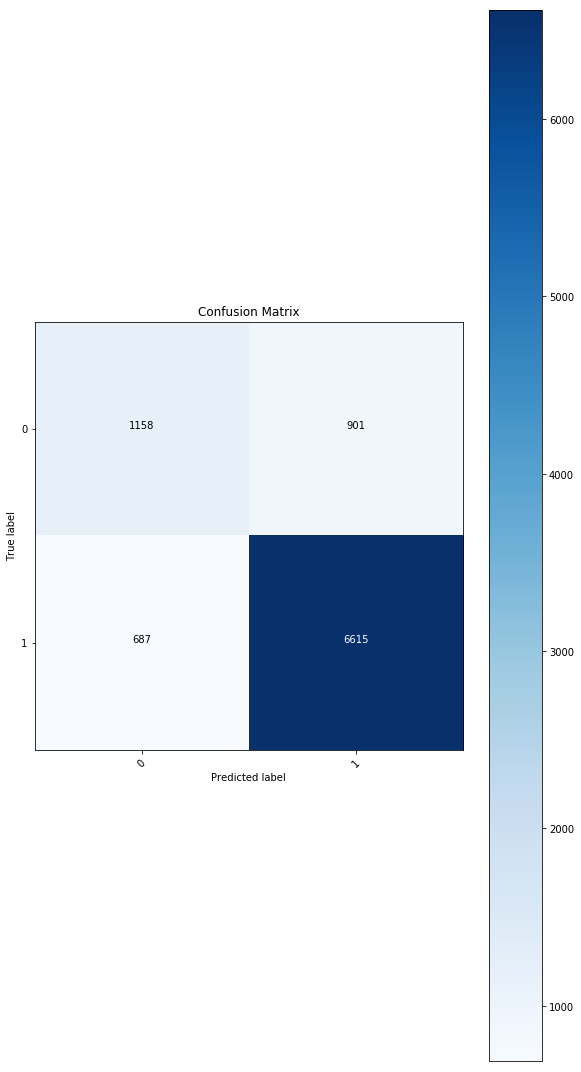

In [110]:
Xlt_rest,Xlt_test, ylt_rest, ylt_test = train_test_split(liwc_text, target,stratify=target, test_size = 0.25, random_state=0)
Xlt_train, Xlt_val, ylt_train, ylt_val = train_test_split(Xlt_rest, ylt_rest, stratify=ylt_rest, test_size = 0.25, random_state=0)

cols = liwc_text.loc[:, liwc_text.columns != 'clean_text'].columns


get_text_data = FunctionTransformer(lambda x: x['clean_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[cols], validate=False)

process_and_join_features = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())
                
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),                 
                ('vec', CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True))

            ]))
         ])), 
    ('clf', LogisticRegression(random_state=0, max_iter=5000, solver='lbfgs', penalty='l2', class_weight='balanced'))
])


#  ('reducer', SelectKBest(chi2, k=100000)

# merge vectorized text data and scaled numeric data
process_and_join_features.fit(Xlt_train, ylt_train)
predictions_lt = process_and_join_features.predict(Xlt_val)


print("Final Accuracy for Logistic: %s"% accuracy_score(ylt_val, predictions_lt))
cm = confusion_matrix(ylt_val,predictions_lt)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(ylt_val, predictions_lt))

In [113]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(process_and_join_features.get_params()['features'].get_params()['text_features'].get_params()['vec'], process_and_join_features.get_params()['clf'], n=20)


	-1.5590	majoring performing		2.2883	grad schoolover
	-1.4212	going shortest 		2.0824	graduated ended
	-1.3463	studying cancer		2.0578	masters ecd    
	-1.3228	major changes  		1.4839	phd free       
	-1.2291	st josephs     		1.3371	graduate imhoping
	-1.2148	student butthat		1.3189	mba international
	-1.2094	finishing gradschool		1.2091	skiing couldspend
	-1.1698	going goofylove		1.0918	teacher city   
	-1.0847	semester spain 		1.0832	law imgood     
	-1.0660	going countrywithout		1.0390	teaching bringing
	-1.0482	schoola cashier		1.0156	lawenforcementi
	-1.0142	school ametalsmithartist		0.9822	engineer creative
	-0.9932	thats rollyou  		0.9581	grade andpossibly
	-0.9544	time tahoeinstead		0.8717	graduated boston
	-0.9364	tattoos ears   		0.8184	educated elegant
	-0.9117	bachelors wasting		0.8134	graduateconsidered
	-0.9074	skateboardyou  		0.7670	snowboarding doodling
	-0.8826	smoking making 		0.7397	nyc eventually 
	-0.8773	happy receivenot		0.7376	balance body   
	-0.8748	college a

# Feature selection(Lasso)

In [58]:
X_train,X_test, y_train, y_test = train_test_split(liwc, target,stratify=target, test_size = 0.25, random_state=0)

scaler = StandardScaler()
liwc_scaled = scaler.fit_transform(X_train)
reg = LassoCV(max_iter=10000)
reg.fit(liwc_scaled, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(liwc_scaled,y_train))
coef = pd.Series(reg.coef_, index = liwc.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.006008
Best score using built-in LassoCV: 0.096257
Lasso picked 41 variables and eliminated the other 52 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

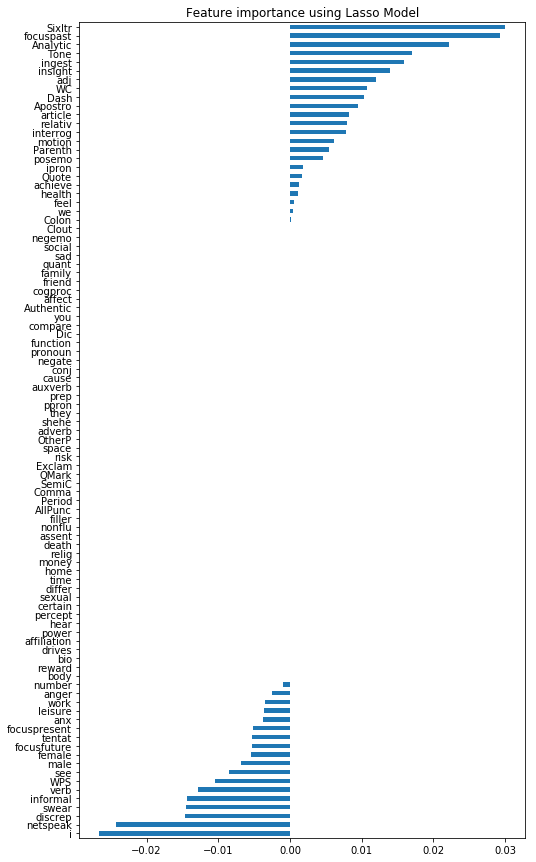

In [59]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 15.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [60]:
new_col = abs(imp_coef).nlargest(43)

new_liwc = liwc[new_col.index]
text = df['clean_text']
liwc_text_new = pd.concat([new_liwc, text], axis=1)


Final Accuracy for Logistic: 0.8318555709860058
Confusion matrix, without normalization
[[1168  891]
 [ 683 6619]]
              precision    recall  f1-score   support

         0.0       0.63      0.57      0.60      2059
         1.0       0.88      0.91      0.89      7302

    accuracy                           0.83      9361
   macro avg       0.76      0.74      0.75      9361
weighted avg       0.83      0.83      0.83      9361



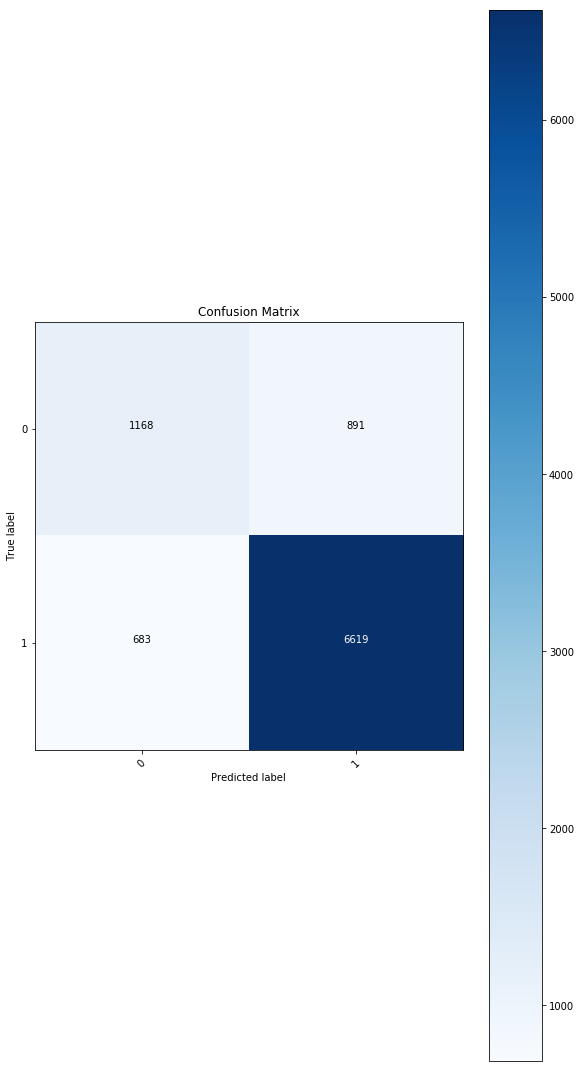

In [54]:
Xlt_rest,Xlt_test, ylt_rest, ylt_test = train_test_split(liwc_text_new, target,stratify=target, test_size = 0.25, random_state=0)
Xlt_train, Xlt_val, ylt_train, ylt_val = train_test_split(Xlt_rest, ylt_rest, stratify=ylt_rest, test_size = 0.25, random_state=0)


cols = liwc_text_new.loc[:, liwc_text_new.columns != 'clean_text'].columns


get_text_data = FunctionTransformer(lambda x: x['clean_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[cols], validate=False)

process_and_join_features = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())
                
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),                 
                ('vec', CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True))

            ]))
         ])), 
    ('clf', LogisticRegression(random_state=0, max_iter=5000, solver='lbfgs', penalty='l2', class_weight='balanced'))
])


# merge vectorized text data and scaled numeric data
process_and_join_features.fit(Xlt_train, ylt_train)
predictions_lt = process_and_join_features.predict(Xlt_val)


print("Final Accuracy for Logistic: %s"% accuracy_score(ylt_val, predictions_lt))
cm = confusion_matrix(ylt_val,predictions_lt)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1], normalize=False,
                      title='Confusion Matrix')
print(classification_report(ylt_val, predictions_lt))

## Most informative words

In [56]:
show_most_informative_features(process_and_join_features.get_params()['features'].get_params()['text_features'].get_params()['vec'], process_and_join_features.get_params()['clf'], n=20)


	-1.5516	majoring exactly		2.2869	grad idea      
	-1.4167	going seehear  		2.0883	graduated calfor
	-1.3439	st croixim     		2.0608	masters city   
	-1.3363	studying aspiring		1.4753	phd cause      
	-1.3270	major aspects  		1.3430	graduate december
	-1.2633	student artinstitute		1.3103	mba dream      
	-1.2305	finishing civilengineer		1.1845	skiing awhilefinding
	-1.1110	semester ideally		1.0681	teacher artist 
	-1.0978	going concertsmovies		1.0543	law cooperation
	-1.0233	going geteverythinghow		1.0381	teaching andwriting
	-1.0209	school xraytech		1.0302	law try        
	-1.0066	school aeducational		0.9723	engineer baby  
	-0.9626	tattoos bit    		0.9631	grad student   
	-0.9395	time suggest   		0.8909	graduate year  
	-0.9332	skateboarding park		0.8528	educated body  
	-0.9281	bachelors incommunications		0.8188	graduate students
	-0.8889	smoking drinking		0.7580	aa fashion     
	-0.8751	college amcreating		0.7466	snowboarding boardgames
	-0.8616	happy pride    		0.7457	balance area